# Poppy Universe – Layer 3: Moon Matrix Model

Welcome to the **Poppy Universe Layer 3 – Moon Matrix notebook**!  
The moon dataset is already fully correct. Here, we focus on **building a matrix-based recommendation model** using simulated user interactions and moon types. This is a **sandbox environment** to test collaborative filtering before the engine consumes it.

> Note: This notebook currently uses **simulated user interactions** to test the Moon matrix.  
> Once we have enough real interactions, the same pipeline will process actual user data for production recommendations.

---

## Goals

1. **Prepare interaction data for matrix factorization**  
   - Map users to moon types  
   - Include weighted interactions (views, clicks, favorites, ratings)  
   - Normalize scores for ML input

2. **Build the User × Moon_Type matrix**  
   - Users in rows, moon types in columns  
   - Populate with interaction strengths  

3. **Perform matrix factorization / prediction**  
   - Generate predicted scores for each user × moon_type  
   - Save intermediate CSV for engine integration

4. **Analyze results**  
   - Identify top moon types per user  
   - Visualize patterns across users and moon types

---

## Folder & File References

- **../../Input_Data/Moons.csv** → Moon dataset  
- **../../Input_Data/Semantic_Type_Interactions.csv** → User interaction dataset  
- **../../Output_Data/Layer3_Moon_Predictions.csv** → Final predictions for engine  
- **Plots/** → Optional heatmaps or visualizations

---

> Note: This notebook focuses **on the moon component** of Layer 3. Planets and stars will have separate notebooks, then merged later.


## 0) Imports

In [48]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

## 1) Load Data

In [49]:
# --- Load interaction dataset ---
# 'backend_df' is injected via papermill by the master notebook if backend data passed the checks
try:
    interactions = backend_df
    print("Using backend-provided interactions")
except NameError:
    # fallback to CSV if running standalone
    interactions = pd.read_csv("../../../Input_Data/MF_Semantic_Type_Interactions.csv")
    print("Using simulated CSV interactions")

# Ensure Timestamp is datetime
interactions['Timestamp'] = pd.to_datetime(interactions['Timestamp'])

# Preview
interactions.head()

Using simulated CSV interactions


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
0,1,86,Star,K,4,2025-12-05 18:42:31.865100
1,2,50,Planet,Terrestrial,1,2025-11-28 04:57:19.070873
2,3,96,Planet,Dwarf Planet,1,2025-12-04 01:06:16.214604
3,4,54,Planet,Ice Giant,3,2025-11-20 07:14:48.239208
4,5,22,Planet,Ice Giant,5,2025-11-14 01:40:03.455302


**Explanation:**  
We’re loading the simulated user × type interaction data to see what we have. The key columns are:
 
- `Interaction_ID`: unique identifier for each interaction  
- `User_ID`: the user who performed the interaction  
- `Category_Type`: the type of category the interaction belongs to (e.g., Star_Type, Planet_Type, Moon_Parent)  
- `Category_Value`: the specific value within the category (e.g., G for Star_Type, Dwarf Planet for Planet_Type)  
- `Strength`: numerical interaction strength (1–5), used as a matrix factorization target  
- `Timestamp`: when the interaction occurred  
 
This gives us the base data we’ll use to compute features like user-type preferences, recency-weighted strengths, and the semantic matrices for the third layer of the recommendation engine.

## 2) Filter out Star and Planet data

In [50]:
# Keep only rows where Category_Type is "Moon"
moon_interactions = interactions[interactions['Category_Type'] == 'Moon']

moon_interactions.head()

,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
12,13,99,Moon,Earth,4,2025-12-02 07:39:42.458023
19,20,85,Moon,Earth,2,2025-11-21 22:00:07.868473
25,26,82,Moon,Pluto,3,2025-12-01 00:47:35.429046
30,31,59,Moon,Eris,4,2025-11-24 08:43:25.777658
41,42,19,Moon,Eris,5,2025-12-08 08:21:23.826144


## 3) Create User × Category Matrix

In [51]:
# Pivot: rows = users, cols = category values, values = max strength (or sum/mean if multiple)
user_category_matrix = moon_interactions.pivot_table(
    index='User_ID', 
    columns='Category_Value', 
    values='Strength', 
    aggfunc='max',   # could also be sum or mean
    fill_value=0     # fills missing interactions with 0
)

# Optional: reset column names if you want a flat DataFrame
user_category_matrix = user_category_matrix.reset_index()

print(user_category_matrix.head())


Category_Value  User_ID  Earth  Eris  Haumea  Jupiter  Makemake  Mars  \
0                     1      1     5       0        0         0     0   
1                     2      0     4       0        5         5     3   
2                     3      5     0       0        0         0     0   
3                     4      5     5       5        5         5     5   
4                     5      4     5       5        5         5     5   

Category_Value  Neptune  Pluto  Saturn  Uranus  
0                     3      3       5       4  
1                     5      0       2       0  
2                     3      5       0       0  
3                     4      0       4       5  
4                     5      5       5       3  


## 4) Matrix Factorization with SGD

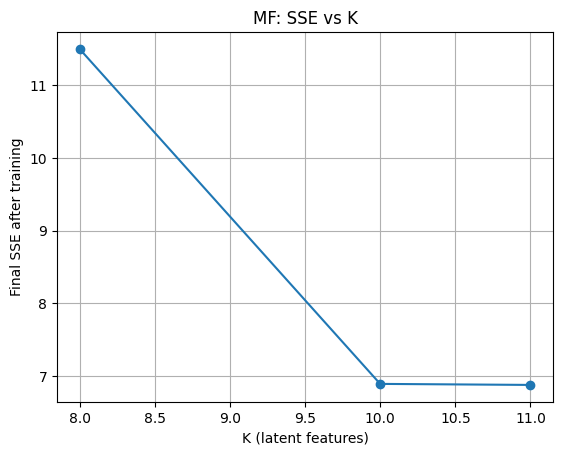

In [ ]:
# Only run this check if you want
run_K_check = False  # set to False to skip

if run_K_check:
    R = user_category_matrix.drop('User_ID', axis=1).values
    num_users, num_items = R.shape
    
    K_values = [8, 10, 11]  # candidate latent features
    alpha = 0.01
    beta = 0.02
    iterations = 1500  # shorter for quick test

    final_sse = []

    for K in K_values:
        np.random.seed(42)
        U = np.random.rand(num_users, K)
        V = np.random.rand(num_items, K)
        sse = 0

        for it in range(iterations):
            total_error = 0
            for i in range(num_users):
                for j in range(num_items):
                    if R[i, j] > 0:
                        pred = U[i, :].dot(V[j, :].T)
                        e_ij = R[i, j] - pred
                        total_error += e_ij**2
                        U[i, :] += alpha * (2 * e_ij * V[j, :] - beta * U[i, :])
                        V[j, :] += alpha * (2 * e_ij * U[i, :] - beta * V[j, :])
            total_error += (beta/2) * (np.sum(U**2) + np.sum(V**2))
            sse = total_error  # keep last SSE

        final_sse.append(sse)

    # Plot SSE vs K
    plt.figure()
    plt.plot(K_values, final_sse, marker='o')
    plt.xlabel("K (latent features)")
    plt.ylabel("Final SSE after training")
    plt.title("MF: SSE vs K")
    plt.grid(True)
    plt.show()

In [53]:
# Convert pivot table to numpy array (exclude User_ID column)
R = user_category_matrix.drop('User_ID', axis=1).values
num_users, num_items = R.shape
K = 10  # See code above 

# Initialize user and item latent matrices randomly
np.random.seed(42)
U = np.random.rand(num_users, K)
V = np.random.rand(num_items, K)

# Hyperparameters
alpha = 0.01
beta = 0.02
iterations = 5000

# Store loss values
sse_history = []

# SGD loop
for it in range(iterations):
    total_error = 0

    for i in range(num_users):
        for j in range(num_items):
            if R[i, j] > 0:
                pred = U[i, :].dot(V[j, :].T)
                e_ij = R[i, j] - pred

                total_error += e_ij ** 2

                U[i, :] += alpha * (2 * e_ij * V[j, :] - beta * U[i, :])
                V[j, :] += alpha * (2 * e_ij * U[i, :] - beta * V[j, :])

    # Regularization
    total_error += (beta / 2) * (np.sum(U**2) + np.sum(V**2))

    sse_history.append(total_error)

# Reconstruct matrix
R_hat = U.dot(V.T)

print("Original matrix:\n", R)
print("Approximated matrix:\n", R_hat)


Original matrix:
 [[1 5 0 0 0 0 3 3 5 4]
 [0 4 0 5 5 3 5 0 2 0]
 [5 0 0 0 0 0 3 5 0 0]
 [5 5 5 5 5 5 4 0 4 5]
 [4 5 5 5 5 5 5 5 5 3]
 [2 4 0 0 0 5 0 0 4 0]
 [5 5 0 0 5 1 0 2 0 4]
 [4 0 0 4 0 3 0 5 0 0]
 [0 5 3 0 0 4 0 0 1 0]
 [5 4 3 2 0 4 0 4 0 0]
 [3 0 5 4 0 5 0 5 4 5]
 [5 0 0 3 0 0 0 0 4 0]
 [4 0 0 0 4 0 0 0 0 3]
 [2 0 4 0 0 0 5 0 5 0]
 [5 5 5 4 3 5 0 5 4 5]
 [3 5 5 5 5 5 5 0 4 5]
 [5 0 0 0 5 3 0 0 5 0]
 [5 0 0 0 0 0 5 5 0 4]
 [4 5 5 4 4 4 5 5 1 5]
 [5 0 3 5 0 0 0 3 0 3]
 [5 5 5 0 5 0 0 1 4 5]
 [3 0 5 4 0 0 0 0 5 4]
 [5 4 0 0 4 0 3 0 0 5]
 [4 3 5 4 0 3 4 0 0 4]
 [5 4 4 0 0 5 0 4 0 3]
 [0 3 0 0 4 4 0 0 1 3]
 [1 3 2 0 0 0 5 4 4 4]
 [0 0 0 3 3 0 0 3 0 0]
 [0 4 5 4 3 4 3 4 4 0]
 [0 0 4 5 5 0 0 3 2 5]
 [0 4 0 0 0 0 0 4 0 0]
 [0 4 3 1 5 2 5 5 3 5]
 [5 4 5 5 3 5 5 5 0 0]
 [3 0 3 5 4 4 0 4 4 3]
 [0 0 0 0 0 1 0 0 5 3]
 [0 4 0 5 0 0 0 4 4 0]
 [0 0 0 0 3 0 5 0 0 4]
 [1 5 5 0 3 4 5 3 4 5]
 [5 0 0 0 3 3 0 3 3 0]
 [5 0 0 4 0 0 3 5 4 0]
 [4 0 0 4 3 0 4 5 0 5]
 [4 0 0 3 0 0 5 5 5 5]
 [0 0 3 4 5 5 0 

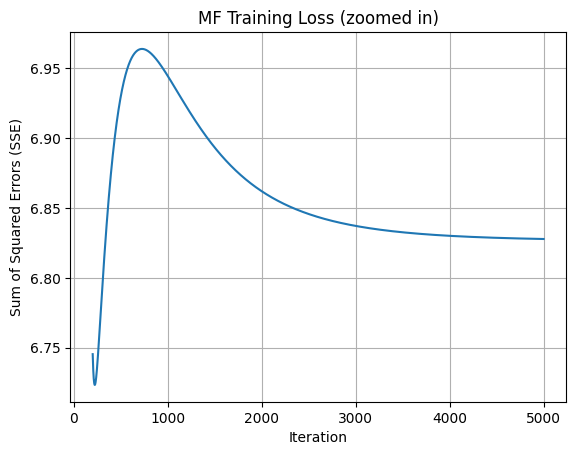

In [54]:
start = 200
end = len(sse_history)

plt.figure()
plt.plot(range(start, end), sse_history[start:end])
plt.xlabel("Iteration")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("MF Training Loss (zoomed in)")
plt.grid(True)
plt.show()

### SSE in Matrix Factorization
**What it is:** Sum of Squared Errors (SSE) measures how far the model's predictions are from the actual values. Lower SSE = better fit.

**How it's calculated:** For each known value, take the difference between the real value and the prediction, square it, and sum all these squared differences.

**How to interpret it:** Low SSE → model captures patterns well. High SSE → data is noisy, sparse, or too complex for the chosen number of latent features.


## 5) Convert Approximated Matrix Back to DataFrame

In [55]:
# Convert R_hat back to DataFrame
R_hat_df = pd.DataFrame(R_hat, columns=user_category_matrix.columns[1:])  # skip User_ID
R_hat_df['User_ID'] = user_category_matrix['User_ID'].values
# Optional: reorder columns so User_ID is first
cols = ['User_ID'] + [c for c in R_hat_df.columns if c != 'User_ID']
R_hat_df = R_hat_df[cols]

R_hat_df.head()

Category_Value,User_ID,Earth,Eris,Haumea,Jupiter,Makemake,Mars,Neptune,Pluto,Saturn,Uranus
0,1,1.034198,4.958568,3.168032,2.867516,3.192717,2.542989,3.011221,3.008631,4.962275,3.983951
1,2,3.729409,3.992734,4.226935,4.964573,4.971852,3.006776,4.968940,3.577834,2.027777,4.012141
2,3,4.986741,3.522922,3.377645,3.522160,3.527539,3.454977,3.001157,4.987488,3.173983,3.400846
3,4,4.987752,4.993597,4.988193,4.981124,4.979210,4.975761,4.013209,4.731958,3.998303,4.973443
4,5,4.005911,4.955454,4.985136,4.968787,4.979890,4.978743,4.974608,4.983476,4.979444,3.045802


## 6) Save Predicted Matrix to CSV

In [56]:
# Save as CSV for master notebook
R_hat_df.to_csv('../Files/Layer3_Moon_Predictions.csv', index=False)

# Optional: preview
print(R_hat_df.head())

Category_Value  User_ID     Earth      Eris    Haumea   Jupiter  Makemake  \
0                     1  1.034198  4.958568  3.168032  2.867516  3.192717   
1                     2  3.729409  3.992734  4.226935  4.964573  4.971852   
2                     3  4.986741  3.522922  3.377645  3.522160  3.527539   
3                     4  4.987752  4.993597  4.988193  4.981124  4.979210   
4                     5  4.005911  4.955454  4.985136  4.968787  4.979890   

Category_Value      Mars   Neptune     Pluto    Saturn    Uranus  
0               2.542989  3.011221  3.008631  4.962275  3.983951  
1               3.006776  4.968940  3.577834  2.027777  4.012141  
2               3.454977  3.001157  4.987488  3.173983  3.400846  
3               4.975761  4.013209  4.731958  3.998303  4.973443  
4               4.978743  4.974608  4.983476  4.979444  3.045802  
